# DQN

In [1]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as autograd
import math, random

In [2]:
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

False


In [3]:
class QLearner(nn.Module):
    def __init__(self, env, args, replay_buffer):
        super(QLearner, self).__init__()

        self.batch_size = args.batch_size
        self.gamma = args.gamma
        self.num_frames = args.num_frames
        self.replay_buffer = replay_buffer
        self.env = env
        self.input_shape = self.env.observation_space.shape
        self.num_actions = self.env.action_space.n
        self.N = args.N

        self.features = nn.Sequential(
            nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
            return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

    def act(self, state, epsilon):
        action = []

        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), \
                               requires_grad=True)
            ######## YOUR CODE HERE! ########
            # TODO: Given state, you should write code to get the Q value and chosen action
            # Complete the R.H.S. of the following 2 lines and uncomment them
            q_value = self.forward(state)
            action = torch.argmax(q_value)
            ######## YOUR CODE HERE! ########
        else:
            action = random.randrange(self.env.action_space.n)
        return action
        
def compute_td_loss(model, batch_size, gamma, replay_buffer):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state = Variable(torch.FloatTensor(np.float32(state)), requires_grad=True)
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), requires_grad=True)
    action = Variable(torch.LongTensor(action))
    reward = Variable(torch.FloatTensor(reward))
    done = Variable(torch.FloatTensor(done))

    ######## YOUR CODE HERE! ########
    # TODO: Implement the Temporal Difference Loss
    q_value = model.forward(state)
    next_q_value = model.forward(next_state)
    
    target = reward + gamma*torch.max(next_q_value)
    current = [q_value[ii,act] for ii, act in enumerate(action)]
    current = Variable(torch.FloatTensor(np.float32(current)), requires_grad=True)
    
    loss = torch.sqrt(torch.mean((current - target)**2))
    ######## YOUR CODE HERE! ########
    return loss


class ReplayBuffer(object):
    def __init__(self, capacity):
        #Returns a new deque object initialized left-to-right
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        ######## YOUR CODE HERE! ########
        # TODO: Randomly sampling data with specific batch size from the buffer
        # Hint: you may use the python library "random".

        batch = random.sample(self.buffer, batch_size)
#         state  = []
#         action = []
#         reward = []
#         next_state = []
#         done = []
#         for sample in batch:
#             state.append(sample[0])
#             action.append(sample[1])
#             reward.append(sample[2])
#             next_state.append(sample[3])
#             done.append(sample[4])

        # If you are not familiar with the "deque" python library, please google it.
        ######## YOUR CODE HERE! ########
        return batch
#         return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)



In [4]:
class Args:
    def __init__(self):
        self.seed=1
        self.batch_size = 32
        self.num_frames = 1000000
        self.gamma = 0.99
        self.epsilon_start = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 0.99
        self.N = 1
        self.optimizer = 'Adam'
        self.lr = 1e-4
        self.capacity = 100000
        self.save_result_path = '../results/DQN/results.npy'
        self.save_model_path = '../results/DQN/weights_only.pth'

In [5]:
args = Args()

In [6]:
aa=torch.tensor([[ 0.0616, -1.5050, -1.2542,  1.0467, -1.6583, -0.1956],
        [ 0.1444, -1.4500, -1.2947,  1.0930, -1.7403, -0.2409],
        [ 0.0342, -1.5723, -1.2624,  1.1574, -1.6852, -0.0689],
        [ 0.0517, -1.5105, -1.2464,  1.1025, -1.6326, -0.1251],
        [ 0.0201, -1.5424, -1.2026,  1.1654, -1.7247, -0.1792],
        [ 0.0877, -1.4870, -1.2158,  1.0617, -1.6393, -0.1004],
        [ 0.0881, -1.4855, -1.2736,  1.1042, -1.5769, -0.1997],
        [ 0.1076, -1.4818, -1.2331,  1.0620, -1.6394, -0.1209],
        [ 0.1458, -1.5549, -1.1906,  1.1144, -1.6783, -0.0942],
        [ 0.0267, -1.5309, -1.3258,  1.0811, -1.6813, -0.1498],
        [ 0.0187, -1.5255, -1.3182,  1.0463, -1.6692, -0.0902],
        [ 0.0642, -1.6106, -1.2788,  1.0466, -1.6537, -0.0168],
        [-0.0481, -1.5233, -1.2429,  1.0540, -1.6389, -0.1518],
        [-0.0229, -1.4506, -1.2753,  0.9652, -1.6470, -0.2397],
        [ 0.0108, -1.5544, -1.1406,  1.1781, -1.7532, -0.1468],
        [ 0.1174, -1.5528, -1.2626,  1.0589, -1.6256, -0.1757],
        [ 0.0499, -1.5252, -1.2493,  1.1104, -1.6591, -0.0693],
        [ 0.0906, -1.5743, -1.2251,  1.0825, -1.6204, -0.0840],
        [ 0.0260, -1.5498, -1.2999,  1.1594, -1.6374, -0.1158],
        [ 0.0567, -1.4924, -1.2527,  1.0692, -1.6544, -0.1253],
        [ 0.0356, -1.5186, -1.3110,  1.1103, -1.7097, -0.0847],
        [ 0.0463, -1.5214, -1.2331,  1.0992, -1.6376, -0.1251],
        [ 0.0372, -1.4996, -1.2329,  1.0936, -1.6099, -0.0969],
        [ 0.0567, -1.5007, -1.2477,  1.0955, -1.6199, -0.1252],
        [ 0.0213, -1.5079, -1.2459,  1.1022, -1.6472, -0.1064],
        [ 0.0600, -1.4948, -1.2267,  1.0692, -1.6599, -0.1107],
        [ 0.0256, -1.5184, -1.2491,  1.1132, -1.6322, -0.1291],
        [ 0.1561, -1.5188, -1.2421,  1.1181, -1.6393, -0.1787],
        [ 0.0355, -1.5439, -1.2369,  1.1085, -1.6272, -0.1101],
        [ 0.0417, -1.4993, -1.3280,  1.0897, -1.6234, -0.1404],
        [ 0.0097, -1.5227, -1.2437,  1.0888, -1.6143, -0.1501],
        [ 0.0409, -1.6244, -1.4683,  1.1526, -1.8225, -0.1008]]) 
print(max(aa[1]))

print(max(aa[1,:]))

tensor(1.0930)
tensor(1.0930)


# run DQN Pong

### Wrappers

In [8]:
import numpy as np
from collections import deque
import gym
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=np.uint8)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

def make_atari(env_id):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env



class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)
    

def wrap_pytorch(env):
    return ImageToPyTorch(env)

ImportError: dlopen(/Users/Maryam/anaconda3/lib/python3.6/site-packages/cv2/cv2.cpython-36m-darwin.so, 2): Symbol not found: _inflateValidate
  Referenced from: /Users/Maryam/anaconda3/lib/python3.6/site-packages/cv2/.dylibs/libpng16.16.dylib (which was built for Mac OS X 10.13)
  Expected in: /usr/lib/libz.1.dylib
 in /Users/Maryam/anaconda3/lib/python3.6/site-packages/cv2/.dylibs/libpng16.16.dylib

In [9]:
# from Wrapper.layers import *
# from Wrapper.wrappers import make_atari, wrap_deepmind, wrap_pytorch
import math, random
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
USE_CUDA = torch.cuda.is_available()
# from dqn import QLearner, compute_td_loss, ReplayBuffer

In [10]:
env_id = "PongNoFrameskip-v4"
env = make_atari(env_id)
env = wrap_deepmind(env, frame_stack=False)
env = wrap_pytorch(env)

In [11]:
state = env.reset()
(state.shape)

NameError: name 'cv2' is not defined

In [12]:
# plot observation of env

In [13]:
# num_frames = 1000000
# batch_size = 32
# gamma = 0.99
    
# replay_initial = 10000
# replay_buffer = ReplayBuffer(100000)
# model = QLearner(env, num_frames, batch_size, gamma, replay_buffer)
# optimizer = optim.Adam(model.parameters(), lr=0.00001)
# if USE_CUDA:
#     model = model.cuda()

# epsilon_start = 1.0
# epsilon_final = 0.01
# epsilon_decay = 30000
# epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

# losses = []
# all_rewards = []
# episode_reward = 0

# state = env.reset()

some tinkering

In [14]:
a = torch.rand(1,5)
print(a)
print(a**2)

tensor([[0.1745, 0.6629, 0.3745, 0.9351, 0.2654]])
tensor([[0.0304, 0.4395, 0.1402, 0.8744, 0.0704]])


In [15]:
num_frames = 10
batch_size = 3
gamma = 0.99

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

replay_buffer = ReplayBuffer(100)
# model = QLearner(env, num_frames, batch_size, gamma, replay_buffer)

state = env.reset()
# Initialize target q function and q function
model_Q = QLearner(env, args, replay_buffer)
model_target_Q = QLearner(env, args, replay_buffer)

for frame_idx in range(100):
        epsilon = epsilon_by_frame(frame_idx)
        action = model_Q.act(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)



NameError: name 'cv2' is not defined

In [16]:
# state, action, reward, next_state, done = replay_buffer.sample(batch_size)
transition = replay_buffer.sample(batch_size)

ValueError: Sample larger than population or is negative

In [23]:
a , b , c , d, e = zip(*transition)
print(np.shape(transition[0][0]))

(1, 1, 84, 84)


In [24]:
state = Variable(torch.FloatTensor(np.float32(state)), requires_grad=True)
next_state = Variable(torch.FloatTensor(np.float32(next_state)), requires_grad=True)
action = Variable(torch.LongTensor(action))
reward = Variable(torch.FloatTensor(reward))
done = Variable(torch.FloatTensor(done))
print(done)

TypeError: new(): data must be a sequence (got numpy.float64)

In [83]:
env.action_space

Discrete(6)

In [100]:
# if USE_CUDA:
#     action = action.cuda()
#     reward = reward.cuda()
# ######## YOUR CODE HERE! ########
# # TODO: Implement the Temporal Difference Loss

# # Compute current Q value, q_func takes only state and output value for every state-action pair
# # We choose Q based on action taken.
# current_q_value = model_Q.forward(state)
# # Compute next Q value based on which action gives max Q values
# # Detach variable from the current graph since we don't want gradients for next Q to propagated
# with torch.no_grad():
#     next_q_value = model_target_Q.forward(next_state).detach()
#     target_q_val = reward + ( (gamma**args.N)* (np.max(next_q_value.detach().cpu().numpy())) * (1-done))

# print(current_q_value.shape)
# print(target_q_val.shape)
# # Compute Bellman error
# loss = torch.mean((target_q_val - current_q_value)**2)

# # loss = torch.nn.SmoothL1Loss(target_q_val, current_q_value)

# # Not sure what this is about
# # # clip the bellman error between [-1 , 1]
# # bellman_error = loss
# # clipped_bellman_error = bellman_error.clamp(-1, 1)
# # # Note: clipped_bellman_delta * -1 will be right gradient
# # d_error = clipped_bellman_error * -1.0

In [118]:
if USE_CUDA:
    action = action.cuda()
    reward = reward.cuda()
print(action)
current_q = model_Q.forward(state)
current_q_value = current_q.gather(1, action.view(-1,1))

with torch.no_grad():
    next_q_value = model_target_Q.forward(next_state).detach()
    target_q_val = reward + ( (gamma**args.N)* (np.max(next_q_value.detach().cpu().numpy())) * (1-done))
target_q_val = target_q_val.view(-1,1)
print(current_q.shape)
print(current_q_value.shape)
print(target_q_val.shape)
# loss = torch.mean((target_q_val - current_q_value)**2)
loss = torch.nn.SmoothL1Loss(target_q_val, current_q_value)

tensor([1, 0, 2])
torch.Size([3, 6])
torch.Size([3, 1])
torch.Size([3, 1])


In [152]:
a = torch.rand(3)
print(a)
b = torch.argmax(a)
print(b.item())
print(b.size())
c = torch.from_numpy(np.array([1,2]))
print (c)
print(int(c.item()))

tensor([0.8305, 0.8839, 0.1926])
1
torch.Size([])
tensor([1, 2])


ValueError: only one element tensors can be converted to Python scalars

In [31]:
# from collections import namedtuple
# Transition = namedtuple('Transition', 
#                         ['state', 'action', 'reward', 'next_state', 'done'])
# batch = zip(*transitions)

In [123]:
a = torch.rand((2,2))
for i in range(2):
    for j in range(2):
        print(a[i,j]*a[i,j])
print(a)
print(a**2)
print(a@a)

tensor(0.2178)
tensor(0.0020)
tensor(0.0819)
tensor(2.9654e-05)
tensor([[0.4667, 0.0447],
        [0.2862, 0.0054]])
tensor([[2.1784e-01, 1.9990e-03],
        [8.1929e-02, 2.9654e-05]])
tensor([[0.2306, 0.0211],
        [0.1352, 0.0128]])


# deep Q run with default params

In [ ]:
num_frames = 1000000
batch_size = 32
gamma = 0.99
    
replay_initial = 10000
replay_buffer = ReplayBuffer(10000)

model = QLearner(env, num_frames, batch_size, gamma, replay_buffer)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
if USE_CUDA:
    model = model.cuda()

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()

In [ ]:
for frame_idx in range(1, num_frames + 1):

    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0

    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(model, batch_size, gamma, replay_buffer)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.cpu().numpy())

    if frame_idx % 10000 == 0 and len(replay_buffer) <= replay_initial:
        print('#Frame: %d, preparing replay buffer' % frame_idx)
        print(len(replay_buffer))
    if frame_idx % 10000 == 0 and len(replay_buffer) > replay_initial:
        print('#Frame: %d, Loss: %f' % (frame_idx, np.mean(losses)))
        print('Last-10 average reward: %f' % np.mean(all_rewards[-10:]))

# Plot

In [1]:
model_result_path = '../results/DQN/model_default_lr3e_5.pth'

replay_initial = 10000 #50000
replay_buffer = ReplayBuffer(args.capacity)

NameError: name 'ReplayBuffer' is not defined

In [30]:
model_new = QLearner(env, args, replay_buffer)
model_new.load_state_dict(torch.load(result_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [17]:
# Environment
env_id = "PongNoFrameskip-v4"
env = make_atari(env_id)
env = wrap_deepmind(env)
env = wrap_pytorch(env)
state = env.reset()
for ii in range(10000000000000):
    epsilon = epsilon_by_frame(frame_idx)
    action = model_new.act(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if ii % 10 == 0:
        env.render()

NameError: name 'cv2' is not defined

In [ ]:
# # Environment
# env_id = "PongNoFrameskip-v4"
# env = make_atari(env_id)
# env = wrap_deepmind(env)
# env = wrap_pytorch(env)
# state = env.reset()
# for ii in range(10000):
#     epsilon = epsilon_by_frame(frame_idx)
#     action = model_new.act(state, epsilon)
#     next_state, reward, done, _ = env.step(action)
#     state = next_state
#     if ii%100==0:
#         env.render()
#         env.close()
#         plt.ioff()
#         plt.show()

In [111]:
import pandas as pd
log_path = '../results/DQN/slurm-90336.out'
# def parse_traning_logs(log_path):
with open(log_path) as logfile :
    raw_log_data = logfile.readlines()
    
    log_data = {}
    set_count = 0
    set_label = None
    frames = []; losses = []; tot_rews = []; avg_all_frames = []; last_ten_avgs = []; best_mean_last_tens = []
    times = []; tot_times = []
    for log in raw_log_data:
        if log.startswith('Frame'):
            frame, loss, tot_rew, avg_all_frame, \
            _, last_ten_avg, _, best_mean_last_ten,\
            time, tot_time = re.findall(r"[-+]?\d*\.\d+|\d+", log)
            frames.append(int(frame))
            losses.append(float(loss))
            tot_rews.append(float(tot_rew))
            avg_all_frames.append(float(avg_all_frame))
            last_ten_avgs.append(float(last_ten_avg))
            best_mean_last_tens.append(float(best_mean_last_ten))
            times.append(float(time))
            tot_times.append(float(tot_time))
        if log.startswith('Namespace'):
            aa = re.findall(r"lr=\d*e[-+]\d*", log)
            _,lr = aa[0].split('=')

        log_data['Learning Rate'] = lr
        log_data['Frames'] = frames
        log_data['Loss'] = losses
        log_data['Total rewards'] = tot_rews
        log_data['Average Rewards over all frames'] = avg_all_frames
        log_data['Mean reward (Past 10 episodes)'] = last_ten_avgs
        log_data['Best Mean reward (Past 10 episodes)'] = best_mean_last_tens
        
        
print('done')
log_data= pd.DataFrame(log_data)

done


In [112]:
int(frame)

960000

In [113]:
log_data

,Learning Rate,Frames,Loss,Total rewards,Average Rewards over all frames,Mean reward (Past 10 episodes),Best Mean reward (Past 10 episodes)
0,3e-05,20000,0.008733,-20.0,-20.500000,-20.7,-20.7
1,3e-05,30000,0.006192,-16.0,-20.096774,-19.2,-19.2
2,3e-05,40000,0.006137,-15.0,-19.684211,-17.9,-17.9
3,3e-05,50000,0.006610,-14.0,-19.272727,-17.0,-17.0
4,3e-05,60000,0.007163,-17.0,-19.020000,-16.7,-16.7
5,3e-05,70000,0.007478,-16.0,-18.821429,-17.2,-16.7
6,3e-05,80000,0.007512,-17.0,-18.540984,-16.5,-16.5
7,3e-05,90000,0.007395,-17.0,-18.388060,-16.0,-16.0
8,3e-05,100000,0.007198,-18.0,-18.236111,-16.6,-16.0
9,3e-05,110000,0.006975,-16.0,-18.090909,-16.1,-16.0


In [114]:
from bokeh.plotting import figure 
from bokeh.models import Legend
from bokeh.layouts import column
from bokeh.io import output_notebook, show

plot_priority_order = [
        'Mean reward (Past 10 episodes)',
        'Best Mean reward (Past 10 episodes)',
        'Loss',
#         'Total rewards',
#         'Average Rewards over all frames',
#         'Learning Rate',
#         'Frames'    
    ]
plots = []
for key in plot_priority_order:
    plots.append(figure(plot_width=900, plot_height=300, y_axis_label=key, x_axis_label='Frames'))
    plots[-1].line(log_data[key].index, log_data[key], line_width=2)
main_row = column(*plots)
show(main_row)

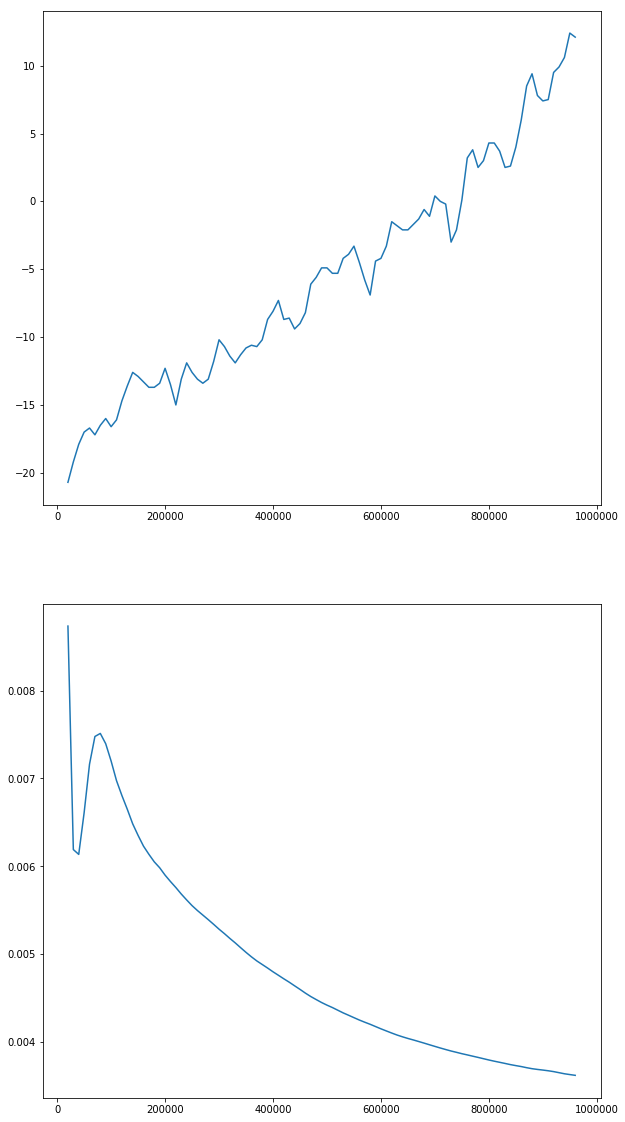

In [124]:
import matplotlib.pyplot as plt

# fig, axis = plt.subplots(1,2)

# plot_priority_order = [
#         'Mean reward (Past 10 episodes)',
# #         'Best Mean reward (Past 10 episodes)',
# #         'Loss',
# #         'Total rewards',
# #         'Average Rewards over all frames',
# #         'Learning Rate',
# #         'Frames'    
#     ]

plt.figure(1,figsize=(10,20))
plt.subplot(211)
plt.plot(log_data['Frames'].values,log_data['Mean reward (Past 10 episodes)'].values)
plt.subplot(212)
plt.plot(log_data['Frames'].values,log_data['Loss'].values)
plt.show()
